---
layout: post
title: PoGo Series&#58; Making a Choropleth Map
comments: true
---

Visualizing the dominance of each Pokemon Go team with a Choropleth map.


<!--more-->

TABLE OF CONTENTS


Welcome to the final post in our Pokemon Go analysis series.  Last time, we cleaned up our tweet collection before counting tweets from each Pokemon Go team in every state.  We used the fraction of tweets about a particular team as a measure of the dominance of that team in the state, and performed a statistical analysis to account for errors in our measurement.  In this post, we'll use Python's `Bokeh` and `Basemap` libraries to visualize our results in a [Choropleth map](http://www.datavizcatalogue.com/methods/choropleth.html).

We'll cover the following topics:

1. [Loading the data](#loading)
2. [Converting RYB fractions to RGB colors](#ryb)
3. [Making an interactive Choropleth map with Bokeh](#bokeh)
4. [Making a Basemap Colored by Prominent Team](#basemap)
5. [Discussing the Analysis Results](#discuss)


# <a name="loading"></a> Loading the data

Before we begin, we'll need to load the data analysis results from our previous post.  

In [1]:
#Import Pandas library
import pandas as pd

#Load the full collection of PoGo tweets
stateInfo = pd.read_csv('stateInfo.csv')
stateInfo_nosenti = pd.read_csv('stateInfo_nosenti.csv')

stateInfo = stateInfo.set_index(['State'])
stateInfo_nosenti = stateInfo_nosenti.set_index(['State'])

stateInfo.head(n=5)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


,Num Tweets,Num Red,Num Blue,Num Yellow,R Frac,Y Frac,B Frac,R Frac Err,Y Frac Err,B Frac Err,Average Rel Err,Improved
State,,,,,,,,,,,,
Pennsylvania,275,111,97,67,0.403636,0.243636,0.352727,0.030429,0.026448,0.029600,0.089287,True
Delaware,27,13,7,7,0.481481,0.259259,0.259259,0.096439,0.084531,0.084531,0.284132,False
Nebraska,64,26,23,15,0.406250,0.234375,0.359375,0.061806,0.053213,0.060367,0.182386,False
Michigan,324,123,115,86,0.379630,0.265432,0.354938,0.027841,0.025192,0.027430,0.081843,True
Idaho,27,11,9,7,0.407407,0.259259,0.333333,0.094828,0.084526,0.090961,0.277224,False


# <a name="ryb"></a> Converting RYB fractions to RGB colors

A [Choropleth map](http://www.datavizcatalogue.com/methods/choropleth.html) divides geographic areas into distinct regions, and colors those regions to visualize patterns in your data.  We can apply this technique to our data to visualize the dominance of each Pokemon Go team in each state.  We'll begin with a map of the United States, with boundaries drawn at the state level.  The fraction of tweets referencing each team in a particular state will tell us how much red, yellow, and blue (RYB) to mix into the color of that state.  For instance, if a particular state has an equal number of blue and yellow team tweets, but no red team tweets, we'd like to color that state green.  

Conventionally, colors are defined on a red, green, and blue (RGB) colorscale.  We need a way to convert our RYB measurements into an RGB measurement.  I modified a [trilinear interpolation method from Gossett and Chen](http://vis.computer.org/vis2004/DVD/infovis/papers/gossett.pdf) for this purpose.  The method requires us to construct a cube of colors on an RYB coordinate system.  The color red would appear at the coordinates (1,0,0) while the color yellow would appear at the coordinates (0,1,0) in this such a system.  Next, we must explicitly map the RYB colors to an RGB basis.  In the case of yellow, the point (0,1,0) in the RYB basis would map to the point (1,1,0) in the RGB basis, since red and green mix to make yellow.  Once we've done this for each point on our cube, we can use a [trilinear interpolation](https://en.wikipedia.org/wiki/Trilinear_interpolation) of the RYB to RGB cube mapping to convert any RYB coordinate to the RGB basis.  The code for doing so is included below:

In [2]:
import numpy as np

def RYB_to_RGB(r,y,b): 

    #Define RYB vectors for each RGB color
    f000=np.array([0,0,0])
    f001=np.array([0,0,1])
    f010=np.array([1,1,0])
    f011=np.array([0,1,0])
    f100=np.array([1,0,0])
    f101=np.array([1,0,1])
    f110=np.array([1,0.647,0])
    f111=np.array([1,1,1])
    
    #Define trilinear interpolation of RYB colors to RGB basis
    rgb=f000*(1-r)*(1-y)*(1-b) +\
        f001*(1-r)*(1-y)*b +\
        f010*(1-r)*y*(1-b) +\
        f100*r*(1-y)*(1-b) +\
        f011*(1-r)*y*b + \
        f101*r*(1-y)*b + \
        f110*r*y*(1-b) + \
        f111*r*y*b
    
    return rgb

We'll need a legend that indicates what each color on our Choropleth map means.  Imagine a triangle whose center lies at the origin of a coordinate system.  The top of the triangle, at $\left(x=1,y=0\right)$, can represent the red color of our map when we only have Team Valor tweets.  The bottom left of the triangle, at $\left(x=\frac{-\sqrt{3}}{2}, y=\frac{-1}{2}\right)$, can represent the yellow color of our map when we only have Team Instinct tweets.  The bottom right of the triangle, at $\left(x=\frac{\sqrt{3}}{2}, y=\frac{-1}{2}\right)$, can represent the blue color of our map when we only have Team Mystic tweets.  To fill in the rest of the triangle, we loop through each possible combination of red team, yellow team, and blue team fractions.  We determine the x and y coordinate of each combination by treating the individual red, yellow, and blue components as a vector and adding the individual vector coordinates together.  We then use our `RYB_to_RGB` function to determine the RGB color of those coordinates.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Create an empty canvas to color in
#Canvas has 2000x2000 pixels, with additional 400 pixels of padding for some labels
pixel_num=2000
word_padding = 400
color_map=np.zeros((pixel_num,pixel_num+word_padding,4)) #Num xbins, Num Ybins, pixel RGBA

#Loop through each red, yellow, blue fraction combination
#Note the constraint r_level+y_level+b_level = 1
for r_level in np.arange(0,1,0.0002):
    y_max = 1-r_level
    for y_level in np.arange(0,y_max,0.0002):
        b_level = 1-r_level-y_level
        
        #Determine RGB color for the RYB combination
        rgb=RYB_to_RGB(r_level,y_level,b_level)

        #Define x,y coordinate of the RGB value
        x_coord = (b_level*np.sqrt(3)/2 - y_level*np.sqrt(3)/2)
        y_coord = (r_level*1 - y_level*(1/2) - b_level*(1/2))
        
        #To convert the triangle y_coord to a canvas coord:
        #Multiply `y_coord` by `pixel_num/2` to take up all pixels in our canvas. 
        canvas_y_coord = y_coord*(pixel_num/2)
        
        #Shift everything up by pixel_num/2 to put y=1 at the top of our canvas.
        canvas_y_coord = canvas_y_coord + (pixel_num/2)
        
        #We have 0.5*(pixel_num/2) unused pixels at the bottom, so shift down by (1/2)*0.5*(pixel_num/2)
        canvas_y_coord = canvas_y_coord - (0.5*(pixel_num/2)*(1/2))
        
        
        
        #To convert the triangle x_coord to a canvas coord:
        #Multiply by pixel_num/2 to take up all pixels
        canvas_x_coord = x_coord*(pixel_num/2)

        #Shift everything by pixel_num/2 to put x=1 at the right of our canvas (without padding)
        canvas_x_coord = canvas_x_coord + (pixel_num/2)
        
        #shift right by half the word padding we alloted
        canvas_x_coord = canvas_x_coord + word_padding/2
        
        
        #Assign the color to the coordinate on our canvas
        color_map[canvas_y_coord,canvas_x_coord,:] = rgb[0],rgb[1],rgb[2],1
     
        

/Users/richardknoche/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

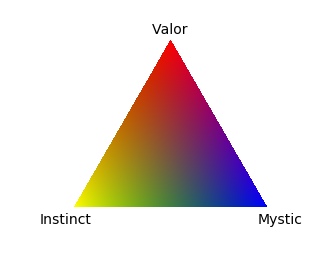

In [5]:
#Display the final canvas
plt.imshow(color_map,origin='lower',interpolation='none')

#Label the corners of the triangle
plt.text(pixel_num/2 + 35, pixel_num-100, 'Valor', fontsize=14, verticalalignment='top')
plt.text(25, word_padding/2, 'Instinct', fontsize=14, verticalalignment='top')
plt.text(pixel_num-25, word_padding/2, 'Mystic', fontsize=14, verticalalignment='top')

#Remove axes
plt.axis('off')

#Save the image
plt.savefig('ColorLegend.png')

# <a name="bokeh"></a> Making an Interactive Choropleth Map with Bokeh </h1>

There are a number of Python libraries we could use to produce our Choropleth map.  In this section, we'll use Python's [Bokeh library](http://bokeh.pydata.org/en/0.11.1/docs/gallery/choropleth.html).  The Bokeh library provides a variety of tools to produce interactive visualizations of data in an html format.  Compared to other plotting libraries such a `matplotlib`, including interactive functionality with Bokeh is a breeze.

First, we need to import a number of tools from the library.

In [3]:
#Import Bokeh
import bokeh

#Functions for manipulating the plot
from bokeh.plotting import figure, output_notebook, show, output_file, ColumnDataSource

#Inline Plotting
output_notebook()

Loading BokehJS ...

Conveniently, Bokeh provides [sample data](https://github.com/bokeh/bokeh/tree/master/bokeh/sampledata) for a number of topics, one of which is geographic information about the boundaries of US states.  We can access this information from `bokeh.sampledata`

In [4]:
from bokeh.sampledata.us_states import data as statesData

The `statesData` object we just imported is a dictionary.  The keys for the dictionary are the abbreviations for each state, and the values of the dictionary define the boundaries of each state by using lists of lattitude and longitude coordinates.  We'll want to extract the coordinates of the boundaries.

In [5]:
#Remove data on Hawaii and Alaska, since they make our map have to zoom out
del statesData["HI"]
del statesData["AK"]

#Extract longitude and lattitude of the state boundaries
state_xs = [statesData[code]["lons"] for code in statesData]
state_ys = [statesData[code]["lats"] for code in statesData]


Next, we need to determine which color to assign to each state on the map.  To do so, we simply use our `RYB_to_RGB` function to convert the fraction of tweets about each team to an RGB color.  Bokeh will want the final color denoted in hexadecimal, so we'll also need to use matplotlib's `rgb2hex` function to convert the RGB color to hex.

Recall that we produced two data frames during our statistical analysis &mdash; one in which we removed negative tweets with our sentiment analyzer and one in which we did not.  We did this because our sentiment analyzer only improved our measurement errors if we collected 50 or more tweets about a particular Pokemon Go team in a particular state.  We distinguished states in which our sentiment analyzer improved our measurement error by marking the "Improved" column as `True`.  When we determine the color of each state, we'll want to extract the team dominance information from whichever data frame has smaller measurement errors.

In [6]:
#Need matplotlib's function to convert RGB to hex code
from matplotlib.colors import rgb2hex


#Create an empty list to store the state colors
state_colors=[]

#Loop over each state
for state in statesData:
    
    #Extract the name of the state
    statename = statesData[state]['name']
    
    #Determine which dataframe to use for the state 
    if stateInfo.ix[statename]['Improved']:
        dFrame = stateInfo
    else:
        dFrame = stateInfo_nosenti
        
    #Determine the RGB color for the state    
    r_level = dFrame.ix[statename]['R Frac']
    y_level = dFrame.ix[statename]['Y Frac']
    b_level = dFrame.ix[statename]['B Frac']                        
    state_colors.append(rgb2hex(tuple(RYB_to_RGB(r_level,y_level,b_level))))

A Choropleth map is a nice way to visualize our data, but it can be difficult to interpret the precise meaning of each color on the map.  Therefore, we'll want to display the exact fraction of tweets referencing each team when a user places their mouse over a state.  To do so, we'll need to place the team dominance measurements, and errors on those measurements, into separate lists for later use.

In [7]:
#Create empty lists for each team dominance measurement
state_names=[]
state_red_frac=[]
state_blue_frac=[]
state_yellow_frac=[]
state_red_frac_err=[]
state_blue_frac_err=[]
state_yellow_frac_err=[]
state_total_count=[]

#Loop over each state
for state in statesData:
    
    #Extract the name of the state
    statename = statesData[state]['name']
    
    #Determine which dataframe to use for the state 
    if stateInfo.ix[statename]['Improved']:
        dFrame = stateInfo
    else:
        dFrame = stateInfo_nosenti
        
    #Determine the team dominance metric for the state  
    r_level = dFrame.ix[statename]['R Frac']
    y_level = dFrame.ix[statename]['Y Frac']
    b_level = dFrame.ix[statename]['B Frac']                        
    
    #Append information to the lists
    state_names.append(statename)
    state_red_frac.append(r_level)
    state_blue_frac.append(b_level)
    state_yellow_frac.append(y_level)
    state_red_frac_err.append(dFrame.ix[statename]['R Frac Err'])
    state_blue_frac_err.append(dFrame.ix[statename]['B Frac Err']) 
    state_yellow_frac_err.append(dFrame.ix[statename]['Y Frac Err'])
    state_total_count.append(dFrame.ix[statename,'Num Tweets'])

Now that we have our data organized and ready to feed into our Choropleth map, we begin to draw the map by creating an empty figure.

In [17]:
#Create the plot    
p = figure(title="Pokemon Go Team Dominance", toolbar_location="left",
           tools="pan,wheel_zoom,box_zoom,reset,hover,save",
           x_axis_location=None, y_axis_location=None, plot_width=630, plot_height=400)
p.grid.grid_line_color = None



We can import all of the information we collected above into Bokeh by feeding it in a as a dict to Bokeh's '`ColumnDataSource` method.

In [18]:
#Import the text data to the plot
data_source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    color=state_colors,
    name=state_names,
    red_frac=state_red_frac,
    blue_frac=state_blue_frac,
    yellow_frac=state_yellow_frac,
    red_frac_err=state_red_frac_err,
    blue_frac_err=state_blue_frac_err,
    yellow_frac_err=state_yellow_frac_err,
    total_count=state_total_count,
    ))

Now, we can tell Bokeh to fill in patches of color inbetween the x and y coordinates of each state.  Once we declare our `data_source` object as the source of information, Bokeh will be able to extract the x and y coordinates of the state boundaries, as well as the color we assigned to each state, by referencing the `data_source` dictionary keys.  

In [19]:
#Color the states
p.patches('x', 'y', source=data_source,
          fill_color='color', fill_alpha=0.7,
          line_color="white", line_width=0.5)


We can include the mouse over functionality we previously discussed using Bokeh's `HoverTool` method.  The `tooltips` method allows us to specify which information we'd like to display during a mouse over.  In this case, I chose to show the state name and the fraction of tweets which refer to each team (along with the errors).  

In [20]:
from bokeh.models import HoverTool

#Include hover over functionality to see text
#{1.111} notation specifies how many decimals to display
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("State", "@name"),
    ("Red Team Fraction", "@red_frac{1.111} +/- @red_frac_err{1.11}"),
    ("Yellow Team Fraction", "@yellow_frac{1.111} +/- @yellow_frac_err{1.11}"),
    ("Blue Team Fraction", "@blue_frac{1.111} +/- @blue_frac_err{1.11}"),
    ("Total Tweets", "@total_count"),
]


After constructing the Choropleth map, we simply need to save it as an html file and tell Python to display the result.

In [21]:
#Output html file
output_file("PoGo_TeamDominance.html", title="Pokemon Go Team Dominance")

#Show the plot
show(p)

# <a name="basemap"></a> Making a Basemap Colored by Prominent Team

Instead of coloring the Choropleth map according to the fraction of tweets which reference each team, we could color the map based on whichever team has the highest fraction of tweets in a particular state.  Such a map would not need mouse over functionality, since the distinct red, blue, and yellow colors would be easy to understand by eye.  We could modify the Bokeh plot code from the previous section to achieve this, but since we don't need the plot to be interactive this is an opportune time to introduce one of the other libraries which allow us to produce Choropleth maps.

First, we need to determine which team "owns" each state.  We do so by comparing the fraction of tweets which reference each team in a particular state.  If the fraction of tweets referencing a particular team is higher than the fraction of tweets referencing each other team, we record the color of that team in a new "Dominant" column. If there is a tie, we simply mix the colors of each team together.  For instance, if there are an equal number of Team Mystic and Team Valor tweets, and both are larger than the fraction of Team Instinct tweets, we color the state purple.   Note that statistically, we can only say that the fraction of tweets about a particular team is higher than the other teams if it exceeds the fraction of tweets about each other team by more than our measurement error.

In [16]:
#Fill in stateInfo dominant column using whichever dataframe is more accruate 
#(even if the data comes from stateInfo_nosenti, we only fill in the Dominant column in the stateInfo dataframe)
for row in range(len(stateInfo)):
    
    #Determine which dataframe to use
    if stateInfo.ix[row]['Improved']:
        dFrame = stateInfo
    else:
        dFrame = stateInfo_nosenti
        
    #Set up variables to make code easy to read     
    r_frac = dFrame.ix[row,'R Frac']   
    r_frac_lower_bound = dFrame.ix[row,'R Frac'] - dFrame.ix[row,'R Frac Err']
    r_frac_upper_bound = dFrame.ix[row,'R Frac'] + dFrame.ix[row,'R Frac Err']

    b_frac = dFrame.ix[row,'B Frac']   
    b_frac_lower_bound = dFrame.ix[row,'B Frac'] - dFrame.ix[row,'B Frac Err']
    b_frac_upper_bound = dFrame.ix[row,'B Frac'] + dFrame.ix[row,'B Frac Err']

    y_frac = dFrame.ix[row,'Y Frac']   
    y_frac_lower_bound = dFrame.ix[row,'Y Frac'] - dFrame.ix[row,'Y Frac Err']
    y_frac_upper_bound = dFrame.ix[row,'Y Frac'] + dFrame.ix[row,'Y Frac Err']

            
    #Check if the red team dominates by more than measurement error    
    if (r_frac > b_frac_upper_bound) and ( r_frac > y_frac_upper_bound):
        stateInfo.ix[row,'Dominant'] = 'red'
        
    #Check if the blue team dominates by more than measurement error            
    elif (b_frac > r_frac_upper_bound) and ( b_frac > y_frac_upper_bound):
        stateInfo.ix[row,'Dominant'] = 'blue'
        
    #Check if the yellow team dominates by more than measurement error        
    elif (y_frac > r_frac_upper_bound) and ( y_frac > b_frac_upper_bound):        
        stateInfo.ix[row,'Dominant'] = 'yellow'
    
    
    #Check for a tie between red and yellow teams   
    elif ( r_frac > b_frac_upper_bound) and (r_frac >= y_frac_lower_bound) and (r_frac <= y_frac_upper_bound):        
        stateInfo.ix[row,'Dominant'] = 'orange'    
        
    #Check for a tie between yellow and blue teams  
    elif ( b_frac > r_frac_upper_bound) and (b_frac >= y_frac_lower_bound) and (b_frac <= y_frac_upper_bound):        
        stateInfo.ix[row,'Dominant'] = 'green'
        
    #Check for a tie between red and blue teams 
    elif ( r_frac > y_frac_upper_bound) and (r_frac >= b_frac_lower_bound) and (r_frac <= b_frac_upper_bound):              
        stateInfo.ix[row,'Dominant'] = 'purple'  
        
    #If none of the above pass, it is a three way tie    
    else:
        stateInfo.ix[row,'Dominant'] = 'white'

We'll use the [Basemap library](https://basemaptutorial.readthedocs.io/en/latest/installation.html) to make this simplified, noninteractive map.  First we need to import the library and some of its functions.

In [17]:
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import matplotlib

#Inline plotting
%matplotlib inline


When we create a Basemap object we need to specify a number of map parameters.  Here's a list of what each [parameter](http://matplotlib.org/basemap/api/basemap_api.html) does:

* `llcrnrlon` sets the longitude of the lower left hand corner of the map domain
* `llcrnrlat` sets the latitude of the lower left hand corner of the map domain
* `urcrnrlon` sets the longitude of the upper right hand corner of the map domain
* `urcrnrlat` sets the latitude of the upper right hand corner of the map domain
* `projection` set the [method for projecting a curved surface](http://matplotlib.org/basemap/users/mapsetup.html) (the earth) onto a 2 dimensional map.
* `lat_0` and `lon_0` set the center of the map domain
* `lat_1` and `lat_2` set the standard parallels for the lambert conformal project that we're using

In [18]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

Next, we'll load a set of [shapefiles](http://basemaptutorial.readthedocs.io/en/latest/shapefile.html) that define the boundaries to draw on our map.  We'll need to find shp, sbf, and shx files that define the boundaries that we want use.  In this case, I used the "st99_d00" shapefiles from [matplotlib's Github page](https://github.com/matplotlib/basemap/tree/master/examples).  To load the shapefiles, we use the `readshapefile` method.  The first argument of this method is the name of our shapefiles (without any extension), the second argument assigns a name to access the shapefile information in our code, and the third argument tells the map that we want to draw solid lines between each of the boundaries.  

We can access the information that our shapefiles imported with the `m.states_info` class member, where the word states will be whatever the second argument in `readshapefile` was set to.  To color in each state in the map we loop through the shapefile information, extracting the state names and creating a dictionary of colors which we wish to associate with those state names. Once we've built the dictionary of colors for each state, we use matplotlib's `poly` and `add_patch` to color in each of the boundaries defined in by our shapefiles.

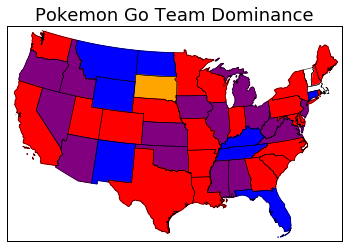

In [38]:
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

#Define empty dictionary and list
colors={}

#Loop through the shapefile information
for nstate, shapedict in enumerate(m.states_info):
    
    #Extract the state name
    statename = shapedict['NAME']
    
    #Extract the color we assigned to that state
    colors[nstate] = stateInfo.ix[statename]['Dominant']
    

#get current axes instance
fig = plt.gcf()
ax = plt.gca() 

#loop through the boundaries defined by our shape map
for nshape,seg in enumerate(m.states):
    
    #Get the color of the state from our dictionary
    color = colors[nshape]
    
    #Use poly to color in the boundary
    poly = Polygon(seg,facecolor=color,edgecolor=color)
    ax.add_patch(poly) 
    

#Show the plot
plt.title('Pokemon Go Team Dominance', size=18)
fig.savefig('PoGo_DominantTeam.png',dpi=300, bbox_inches='tight')        

# <a name="discuss"></a> Discussing the analysis results

If we only look at the basemap result, we see that Team Valor is the most dominant team in 23 states.  Team Mystic claims eight states, and ties for ownership with Team Valor in 18 states (including Peurto Rico and DC).  Team Instinct seems less popular, only having shared ownership of three states.  In two of the states, we could not say that any particular team owned the state with statistical signifance.

The popularity of the Pokemon Go teams are not as one sided as the Basemap would lead you to believe.  Our interactive Bokeh plot shows that the majority of states are tinted purple when you account for the fraction of tweets from every team in the state.  This indicates that even though Team Valor is the most dominant team in many states, Team Mystic is a close second in popularity.  In fact, if we look at the total number of tweets about each team, regardless of the location of those tweets, we see that Team Valor represents 40 $\pm$ 1% of our tweets, Team Mystic represents 37 $\pm$ 1% of our tweets, and Team Instinct represents 23 $\pm$ 0.5% of our tweets.

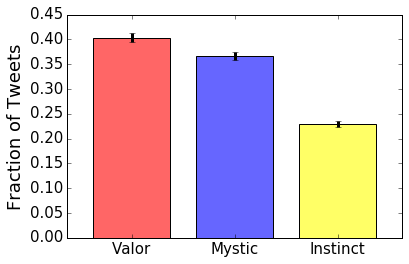

In [43]:
#Counting tweets regardless of origin
red_tweets= sum(stateInfo['Num Red'])
blue_tweets = sum(stateInfo['Num Blue'])
yellow_tweets = sum(stateInfo['Num Yellow'])

#Statistical analysis -- same strategy as in the previous blog post
sys_err = 0.024
red_err = np.sqrt(red_tweets + (red_tweets*sys_err)**2 )
blue_err = np.sqrt(blue_tweets + (blue_tweets*sys_err)**2 )
yellow_err = np.sqrt(yellow_tweets + (yellow_tweets*sys_err)**2 )

r_frac = red_tweets/(red_tweets + blue_tweets + yellow_tweets)
b_frac = blue_tweets/(red_tweets + blue_tweets + yellow_tweets)
y_frac = yellow_tweets/(red_tweets + blue_tweets + yellow_tweets)

r_frac_err = ( (red_err ** 2)*(blue_tweets + yellow_tweets)**2 + \
              red_tweets**2 * (blue_err**2 + yellow_err**2) ) ** (1/2) / \
             (yellow_tweets + blue_tweets + red_tweets)**2

y_frac_err = ( (yellow_err ** 2)*(red_tweets + blue_tweets)**2 + \
              yellow_tweets**2 * (blue_err**2 + red_err**2) ) ** (1/2) / \
             (yellow_tweets + blue_tweets + red_tweets)**2


b_frac_err = ( (blue_err ** 2)*(yellow_tweets + red_tweets)**2 + \
               blue_tweets**2 * (yellow_err**2 + red_err**2) ) ** (1/2) / \
             (yellow_tweets + red_tweets + blue_tweets)**2    
      
#Make bar graph
bar_width = 0.3
fig, ax = plt.subplots()

#Bars
rects1 = ax.bar(0, r_frac, bar_width, color=[1,0,0,0.6])
rects2 = ax.bar(0.4, b_frac, bar_width, color=[0,0,1,0.6])
rects3 = ax.bar(0.8, y_frac, bar_width, color=[1,1,0,0.6])

#Errors on the bars
plt.errorbar(0+bar_width/2,r_frac, yerr=r_frac_err, color='black', fmt='.', markersize='1', ecolor='black', elinewidth=3)
plt.errorbar(0.4+bar_width/2,b_frac, yerr=b_frac_err, color='black', fmt='.', markersize='1', ecolor='black', elinewidth=3)
plt.errorbar(0.8+bar_width/2,y_frac, yerr=y_frac_err, color='black', fmt='.', markersize='1', ecolor='black', elinewidth=3)

#Plot labeling
ax.set_ylabel('Fraction of Tweets',size = 18)
ax.set_xticks(np.array([0,0.4,0.8]) + bar_width/2)
ax.set_xticklabels(('Valor', 'Mystic', 'Instinct'),size=18)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim([-0.1, 1.2])
plt.savefig('PoGo_Bar.png',dpi=300,bbox_inches='tight',pad_inches=0.5)

# Closing remarks

It too a lot of work, but we succesfully used Twitter to quantify the dominance of the Pokemon Go teams in each state.  Along the way we learned details of the Twitter API, and how to use Python's Tweepy library to interface with the API and collect tweets. We built an understanding of Naive Bayes Classifiers, and trained one to classify the sentiment of each tweet that we collected.  We used the sentiment analyzer to remove negative tweets from our collection, along with the multi-team tweets, and repeated-user tweets that we removed with Pandas.  With the cleaned data, we performed a statistical analysis to determine the dominance of each Pokemon Go team in every state while properly accounting for errors on our measurement.  Finally, we visualized discussed our results in this final post.  Congratulations on making it through the six-post series.  If you learned anything useful along the way, or have any questions about the topics we covered, feel free to leave a comment below. 